In [22]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def read_10x_tsv(path):
    """
    Read 10x tsv files into anndata object
    """
    adata = ad.read_csv(path, delimiter='\t')
    return adata

ilmn_h5 = sc.read_10x_h5('../../illumina/filtered_feature_bc_matrix.h5')


/Users/remi.olsen/opt/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/remi.olsen/opt/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3939 × 32285
    var: 'gene_ids', 'feature_types', 'genome'


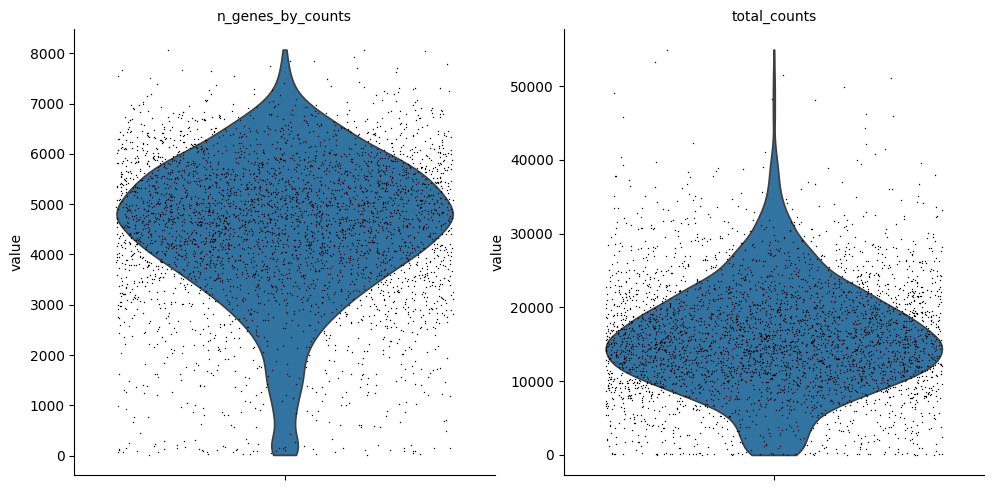

In [23]:
# QC
#adata = gene_expression.T
adata = ilmn_h5
adata.var_names_make_unique()
print(adata)
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("Mt")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    jitter=0.4,
    scale="width",
    multi_panel=True,
)

#sc.pl.scatter(adata, "total_counts", "n_genes_by_counts")

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

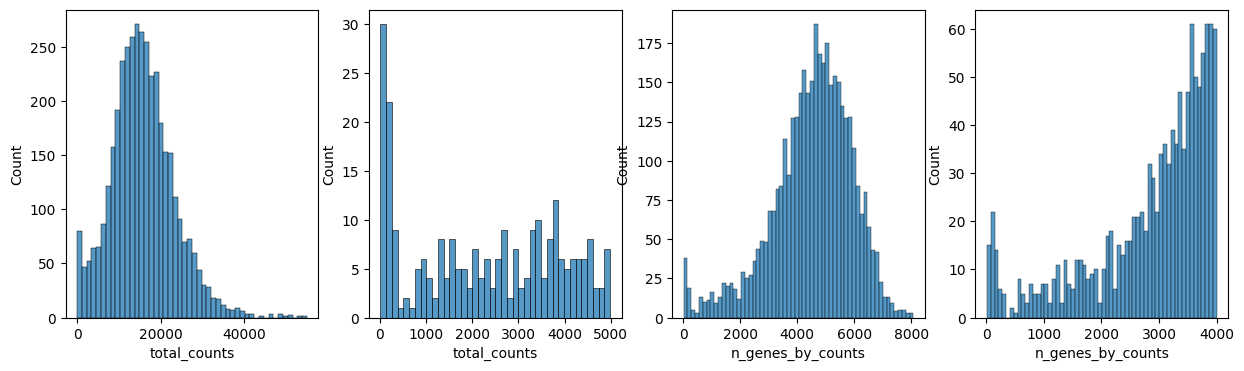

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 5000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [25]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", flavor="igraph", directed=False, resolution=0.3
)
adata.var["highly_variable"]

Xkr4          False
Gm1992        False
Gm19938       False
Gm37381       False
Rp1           False
              ...  
AC124606.1    False
AC133095.2    False
AC133095.1    False
AC234645.1    False
AC149090.1     True
Name: highly_variable, Length: 32285, dtype: bool

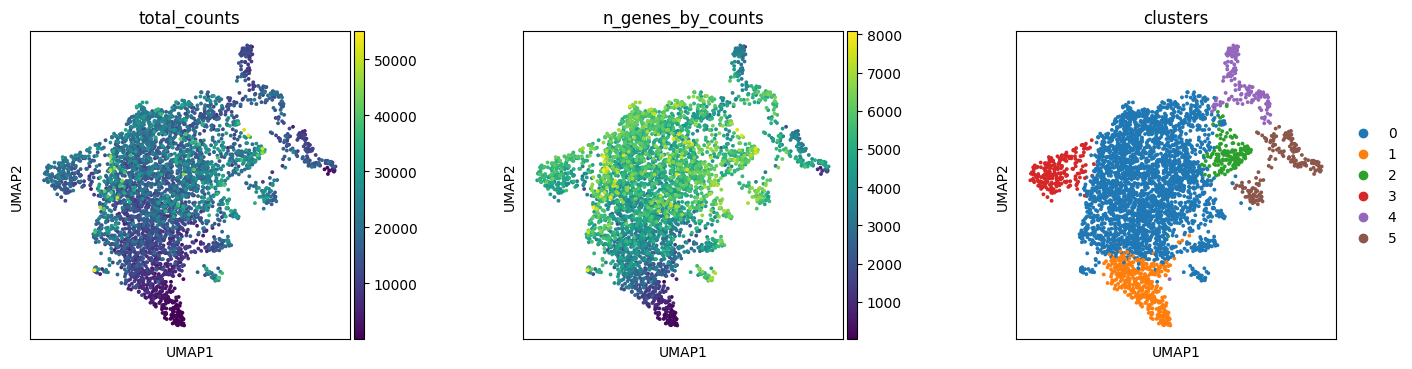

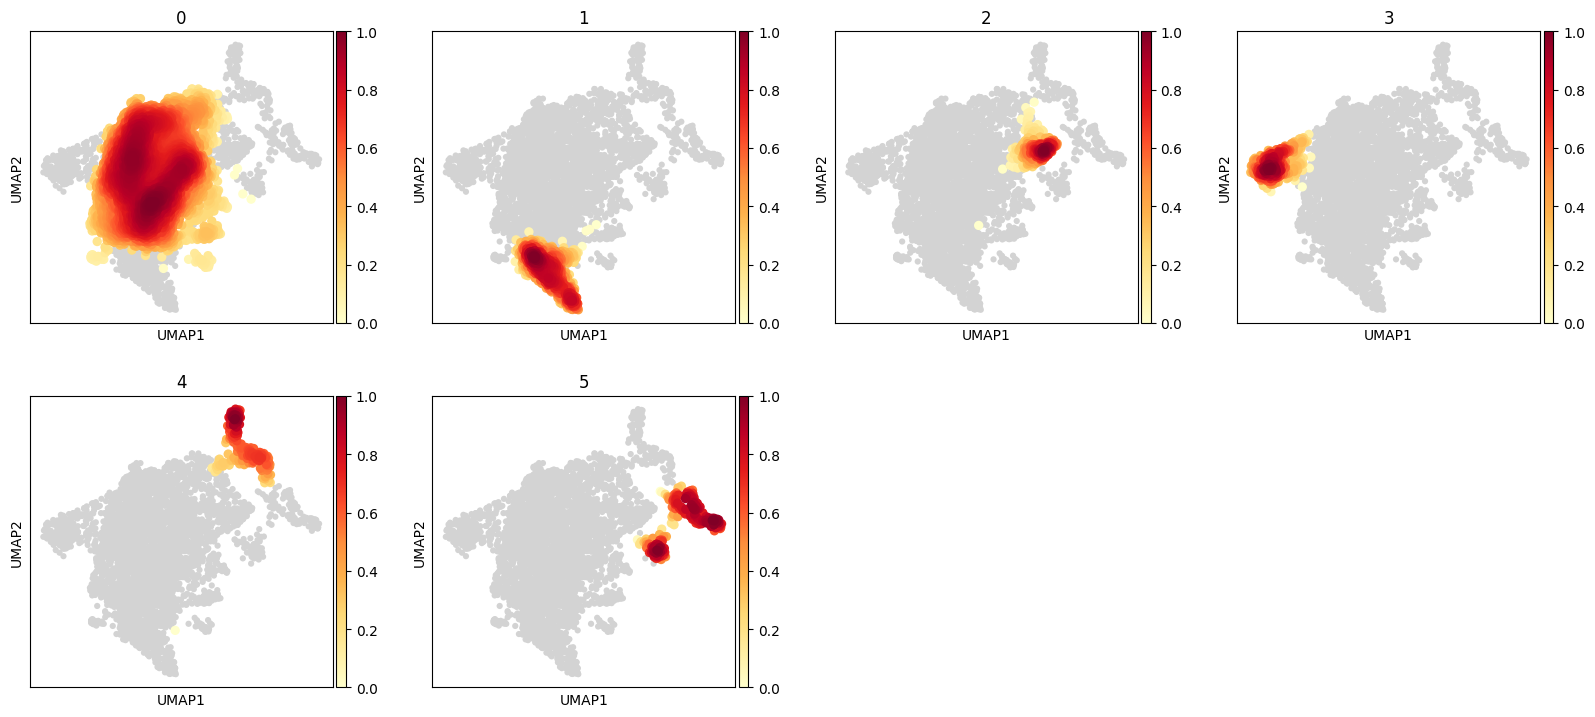

In [26]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)
sc.tl.embedding_density(adata, basis="umap", groupby="clusters")
sc.pl.embedding_density(adata, groupby="clusters", ncols=4)

# Transpose for next step

AnnData object with n_obs × n_vars = 3939 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'clusters', 'umap_density_clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'clusters', 'clusters_colors', 'umap_density_clusters_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


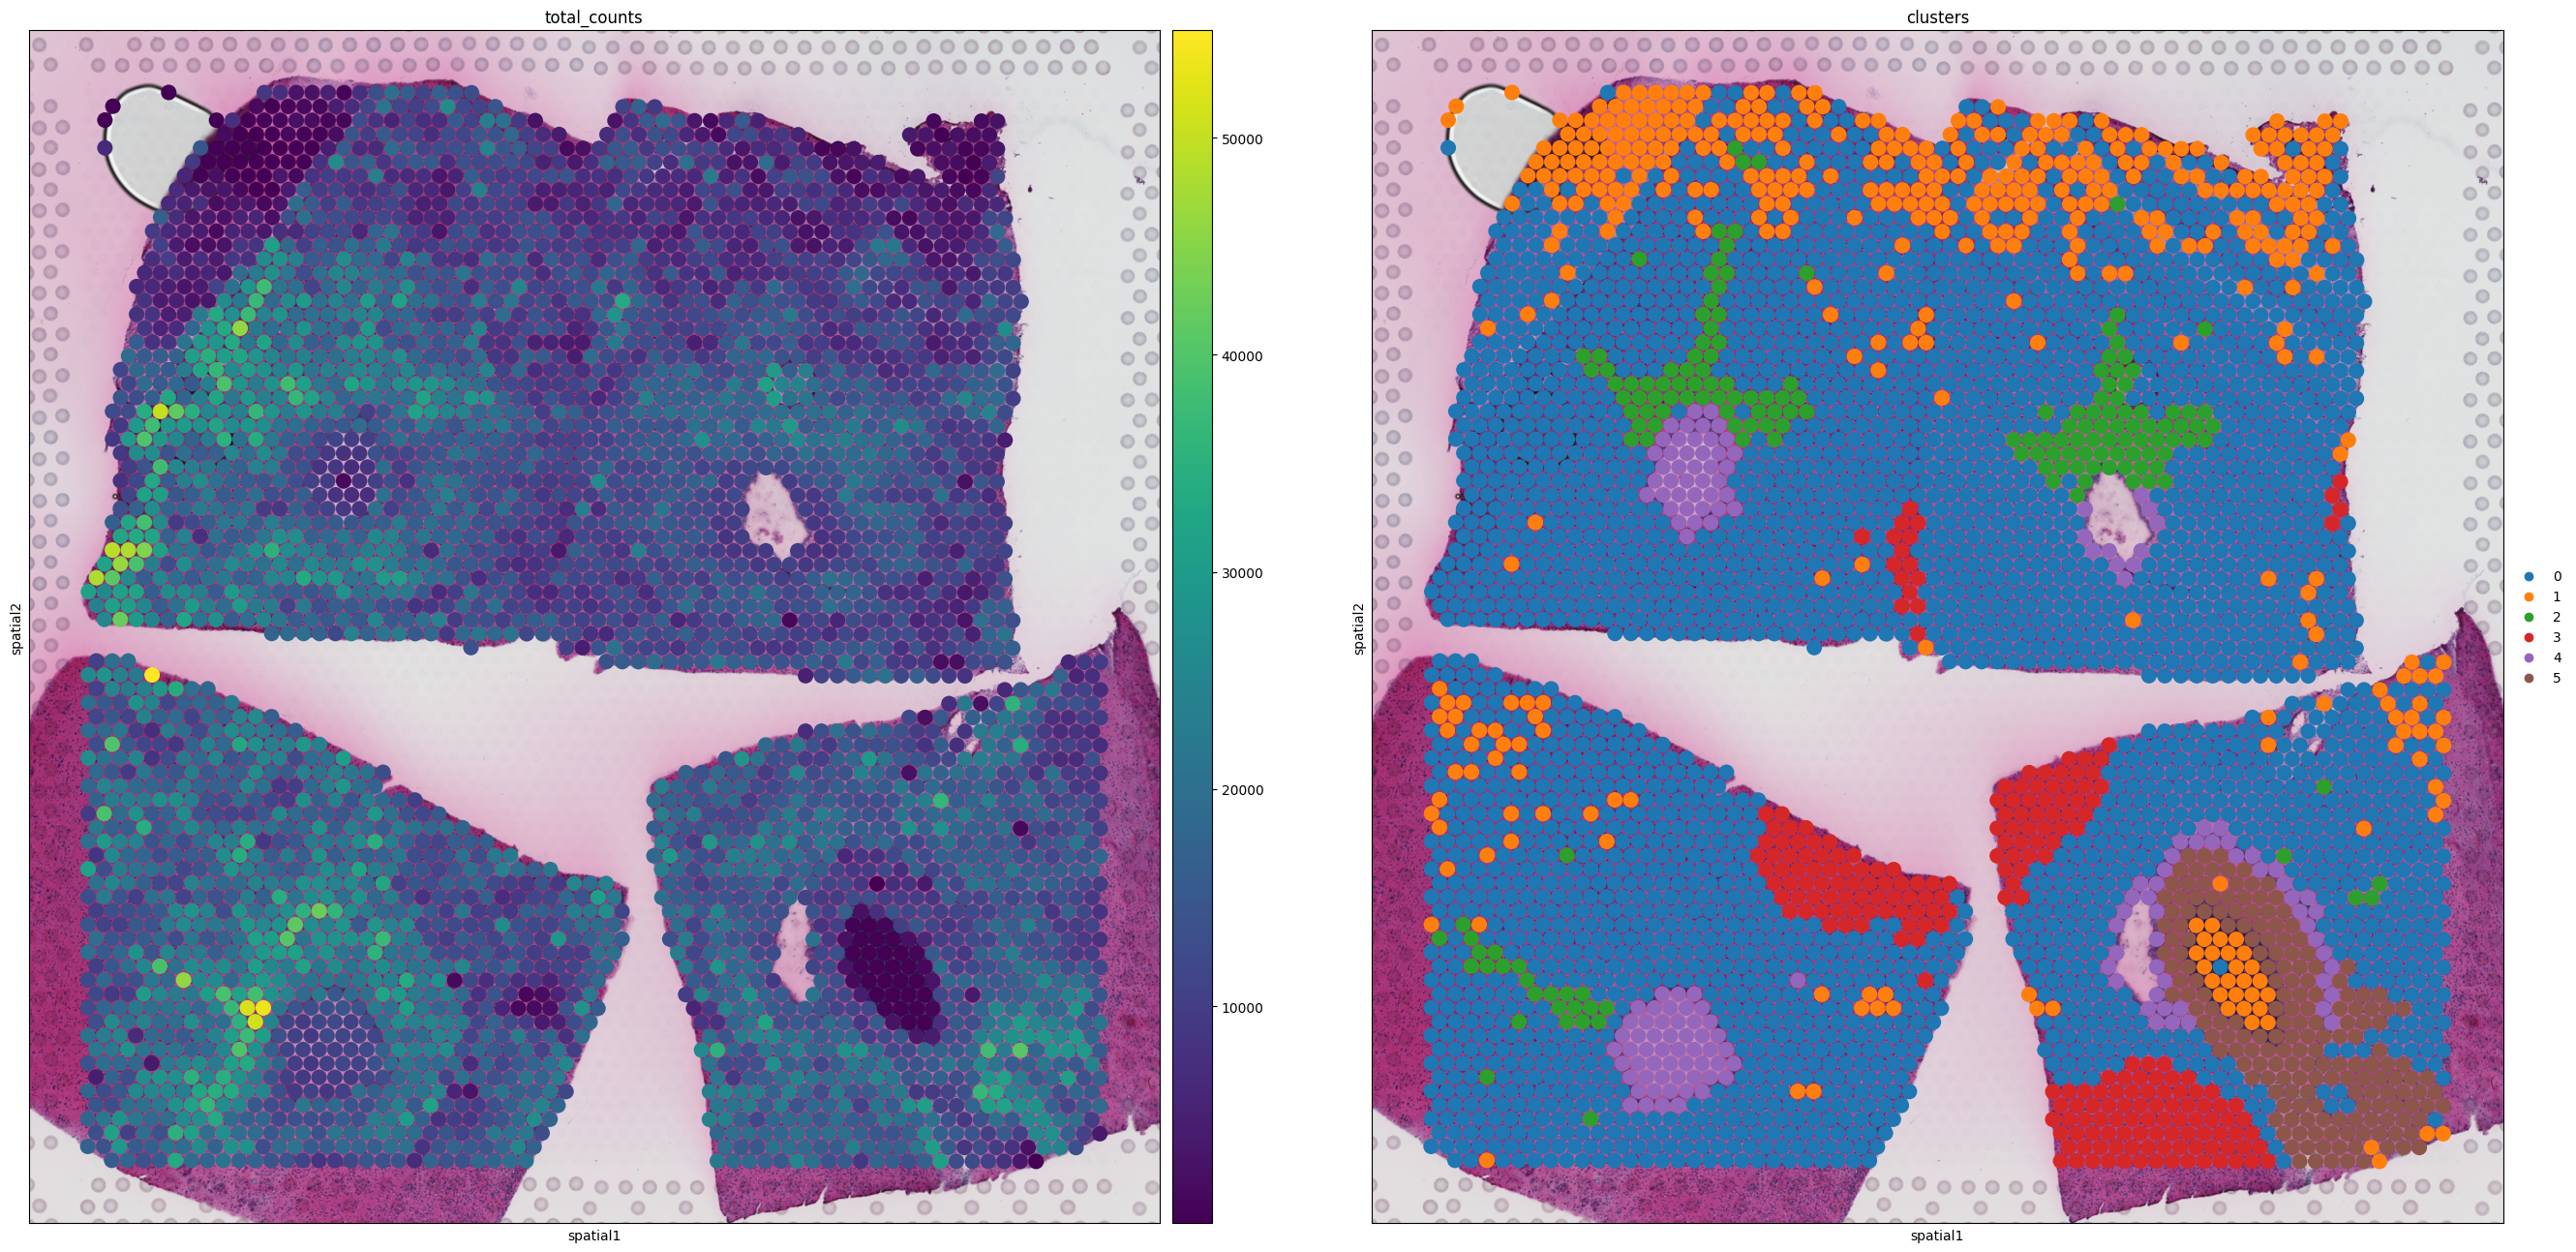

In [27]:

#adata = gene_expression.T


whitelist_f = "../data/fastq_pass.whitelist.tsv"
whitelist = pd.read_csv(whitelist_f, header=None, names=["barcode"])
image = "../data/spatial/tissue_hires_image.png"

# Load image as numpy array
from PIL import Image
img = Image.open(image)
img_d = np.array(img)

coordinates_f = "../data/spatial/tissue_positions_list.csv"
coordinates = pd.read_csv(coordinates_f, header=None, names=["barcode", "in_tissue", "array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"])
#coordinates["barcode"] = coordinates["barcode"].str.split("-").str[0]

# Sort coordinates by barcode or else this will not work
coordinates = coordinates.sort_values(by="barcode")  

# Only keep coordinates which are found in adata
coordinates = coordinates[coordinates["barcode"].isin(adata.obs_names)]

print(adata)
spatial_key = "spatial"
library_id = "P25551A1"
adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns[spatial_key][library_id]["images"] = {"hires": img_d}
adata.uns[spatial_key][library_id]["scalefactors"] = {
    "tissue_hires_scalef": 0.04245924,
    "spot_diameter_fullres": 377.4949302508056,
}
adata.obsm["spatial"] = coordinates[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values

plt.rcParams["figure.figsize"] = (16, 16)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "clusters"], library_id=library_id, size=1.5)

In [28]:
adata.obs["total_counts"]

AAACAAGTATCTCCCA-1    22073.0
AAACAATCTACTAGCA-1     7443.0
AAACACCAATAACTGC-1    28467.0
AAACAGAGCGACTCCT-1    12268.0
AAACAGCTTTCAGAAG-1    29200.0
                       ...   
TTGTTGTGTGTCAAGA-1    14729.0
TTGTTTCACATCCAGG-1     8105.0
TTGTTTCATTAGTCTA-1    24347.0
TTGTTTGTATTACACG-1    15418.0
TTGTTTGTGTAAATTC-1    11933.0
Name: total_counts, Length: 3939, dtype: float32